In [6]:
library(HarmonizR)
library(tidyverse)

source("../../evaluation_utils/plots_eda.R")

Warning message:
“package ‘dplyr’ was built under R version 4.3.3”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


Warning message:
“package ‘patchwork’ was built under R version 4.3.3”
Warning message:
“package ‘umap’ was built under R version 4.3.3”
Warning message:
“package ‘ggsci’ was built under R version 4.3.3”
Loading required package: viridisLite



In [7]:
# r version
R.Version()$version.string


[1] "R version 4.3.2 (2023-10-31)"

In [8]:
# harmonizR version
packageVersion("HarmonizR")

[1] ‘0.99.2’

# Load data

In [9]:
all_expression <- read.table("before/all_expression_UNION.tsv", header = TRUE, sep = "\t", row.names = 1)
all_metadata <- read.table("before/all_metadata.tsv", header = TRUE, sep = "\t", row.names = 1)

# for this remove GSE26712 Dataset samples
all_metadata <- all_metadata %>%
    filter(Status == "normal" | Status == "ovarian tumour" & HistSubtypes == "high-grade serous carcinoma")
all_expression <- all_expression[, rownames(all_metadata)]

print(paste0("Number of features: ", nrow(all_expression), " Number of samples: ", ncol(all_expression)))
print(paste0("Number of metadata columns: ", ncol(all_metadata), " Number of metadata samples: ", nrow(all_metadata)))


[1] "Number of features: 51276 Number of samples: 332"
[1] "Number of metadata columns: 6 Number of metadata samples: 332"


In [10]:
all_metadata <- all_metadata %>%
    mutate(Status = as.factor(Status),
           dataset = as.factor(Dataset))
all_metadata$Sample_geo_ID <- rownames(all_metadata)

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


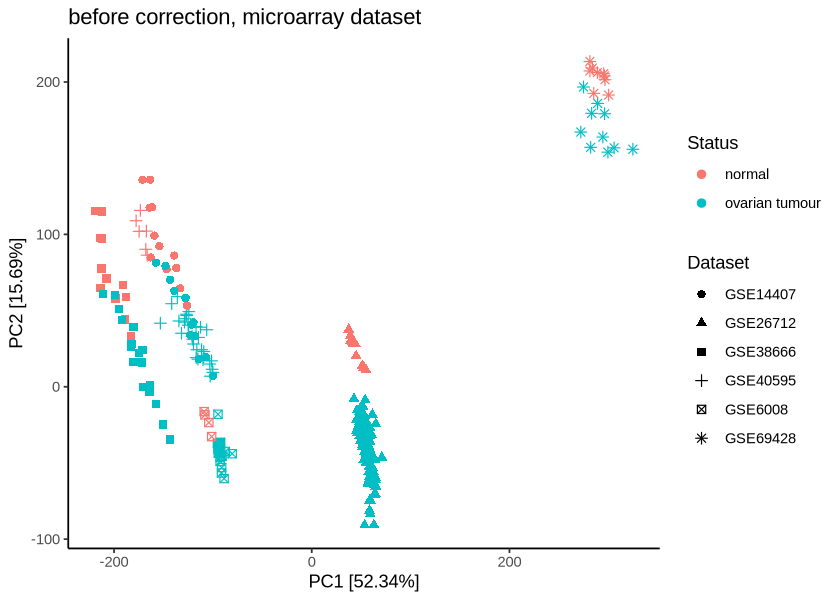

In [11]:
before_correction_pca <- pca_plot(
    na.omit(all_expression), all_metadata, 
    "before correction, microarray dataset",
    col_col="Status", shape_col="Dataset", 
    quantitative_col_name = 'Sample_geo_ID')

options(repr.plot.width=7, repr.plot.height=5)
before_correction_pca

# Correction

In [12]:
design <- model.matrix(~all_metadata$Status)
colnames(design) <- c("Intercept", "HGSC")

## Using limma

In [13]:
corrected_limma <- limma::removeBatchEffect(
        all_expression, 
        batch = all_metadata$Dataset, 
        design = design) %>% 
    as.data.frame()


Warning message:
“Partial NA coefficients for 30148 probe(s)”


In [14]:
print(paste0("Number of features: ", nrow(all_expression), " Number of samples: ", ncol(all_expression)))
all_metadata %>%
    group_by(Dataset) %>% summarise(n())

[1] "Number of features: 51276 Number of samples: 332"


Dataset,n()
<chr>,<int>
GSE14407,24
GSE26712,195
GSE38666,30
GSE40595,37
GSE6008,27
GSE69428,19


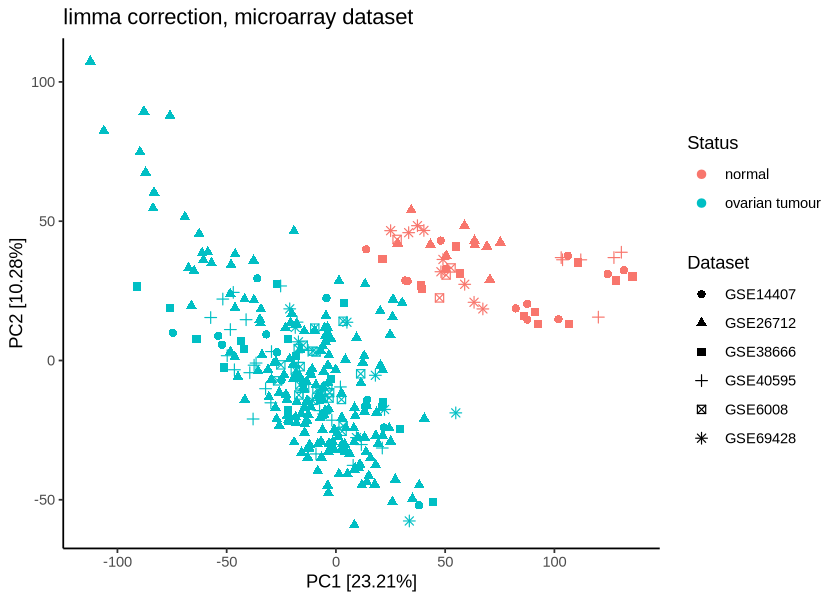

In [15]:
after_limma_pca <- pca_plot(
    na.omit(corrected_limma), all_metadata, 
    "limma correction, microarray dataset",
    col_col="Status", shape_col="Dataset", 
    quantitative_col_name = 'Sample_geo_ID')

options(repr.plot.width=7, repr.plot.height=5)
after_limma_pca

## Using HarmonizR

In [16]:
design_hz = all_metadata %>%
    select(Sample_geo_ID, Dataset) %>%
    mutate(batch = as.numeric(as.factor(Dataset)),
           sample = c(1:ncol(all_expression)),
           ID = Sample_geo_ID) %>%
    select(-Dataset, -Sample_geo_ID) %>%
    select(ID, sample, batch)

In [17]:
print(paste0("Number of features: ", nrow(all_expression), " Number of samples: ", ncol(all_expression)))
all_metadata %>%
    group_by(Dataset) %>% summarise(n())

[1] "Number of features: 51276 Number of samples: 332"


Dataset,n()
<chr>,<int>
GSE14407,24
GSE26712,195
GSE38666,30
GSE40595,37
GSE6008,27
GSE69428,19


In [18]:
HarmonizR::harmonizR(
    all_expression, 
    design_hz) -> harmonized

Initializing HarmonizR...



Reading the files...

Preparing...

Splitting the data using ComBat adjustment...

Rebuilding...

Writing file...

Termination.



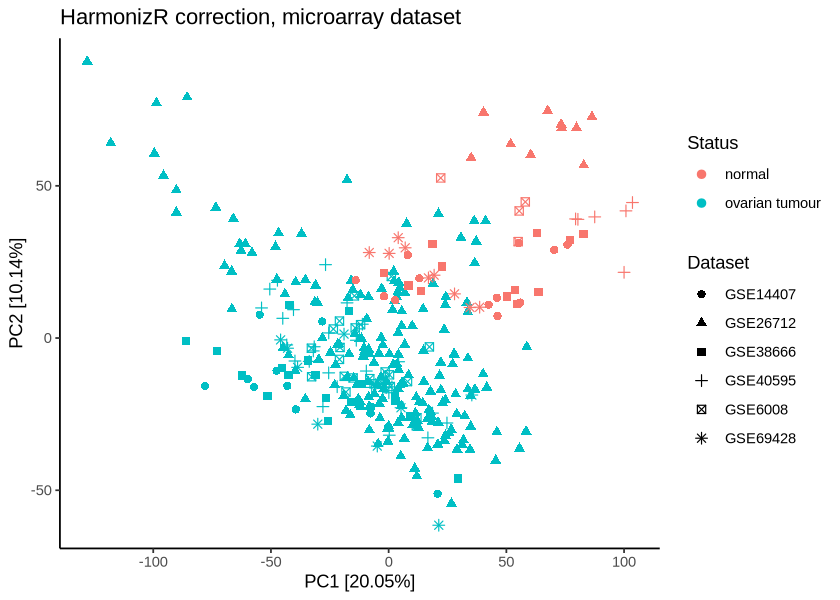

In [19]:
after_H_pca <- pca_plot(
    na.omit(harmonized), all_metadata, 
    "HarmonizR correction, microarray dataset",
    col_col="Status", shape_col="Dataset", 
    quantitative_col_name = 'Sample_geo_ID')

options(repr.plot.width=7, repr.plot.height=5)
after_H_pca

##  Linear model per variable

In [20]:
library(variancePartition)

In [25]:
# version of variancePartition
packageVersion("variancePartition")

[1] ‘1.30.2’

In [21]:
lmpv_plot <- function(data, metadata, title, y_limits = c(0, 1), show_legend = T){
  form <- ~ Status + Dataset

  varPart <- fitExtractVarPartModel(na.omit(data), form, metadata)
  variance_col <- as.matrix(varPart[,1:2])

  df_long <- reshape2::melt(variance_col)

  # Plotting the boxplots using ggplot2
  res_plots <- ggplot(df_long, aes(x = Var2, y = value, fill=Var2)) +
    geom_boxplot() +
    labs(title = title,
          y = "Proportion Variance", x = "Column") +
        scale_fill_discrete(name = "Column") +
    theme_minimal() +
    ylim(y_limits)

  # add mean value near box
  res_plots <- res_plots + 
    geom_text(data = df_long %>% group_by(Var2) %>% summarise(mean = mean(value)),
              aes(x = Var2, y = mean, label = round(mean, 2)), 
              vjust = -0.5, size = 3, color = "black")


  if(!show_legend){
    res_plots <- res_plots + 
    theme(legend.position = "none")
  }

  return(res_plots)
}

In [22]:
lmpv_plots_Rcorrected <- lmpv_plot(corrected_limma, all_metadata,
    title = paste("LMVP, after limma, OV cancer, microarray"))
lmpv_plot_Hcorrected <- lmpv_plot(harmonized, all_metadata,
    title = paste("LMVP, after HarmonizR, OV cancer, microarray"), show_legend=F)
lmpv_plot_uncorrected <- lmpv_plot(all_expression, all_metadata,
    title = paste("LMVP, before, OV cancer, microarray"), show_legend=F)


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack



Total:76 s


Total:75 s


Total:76 s



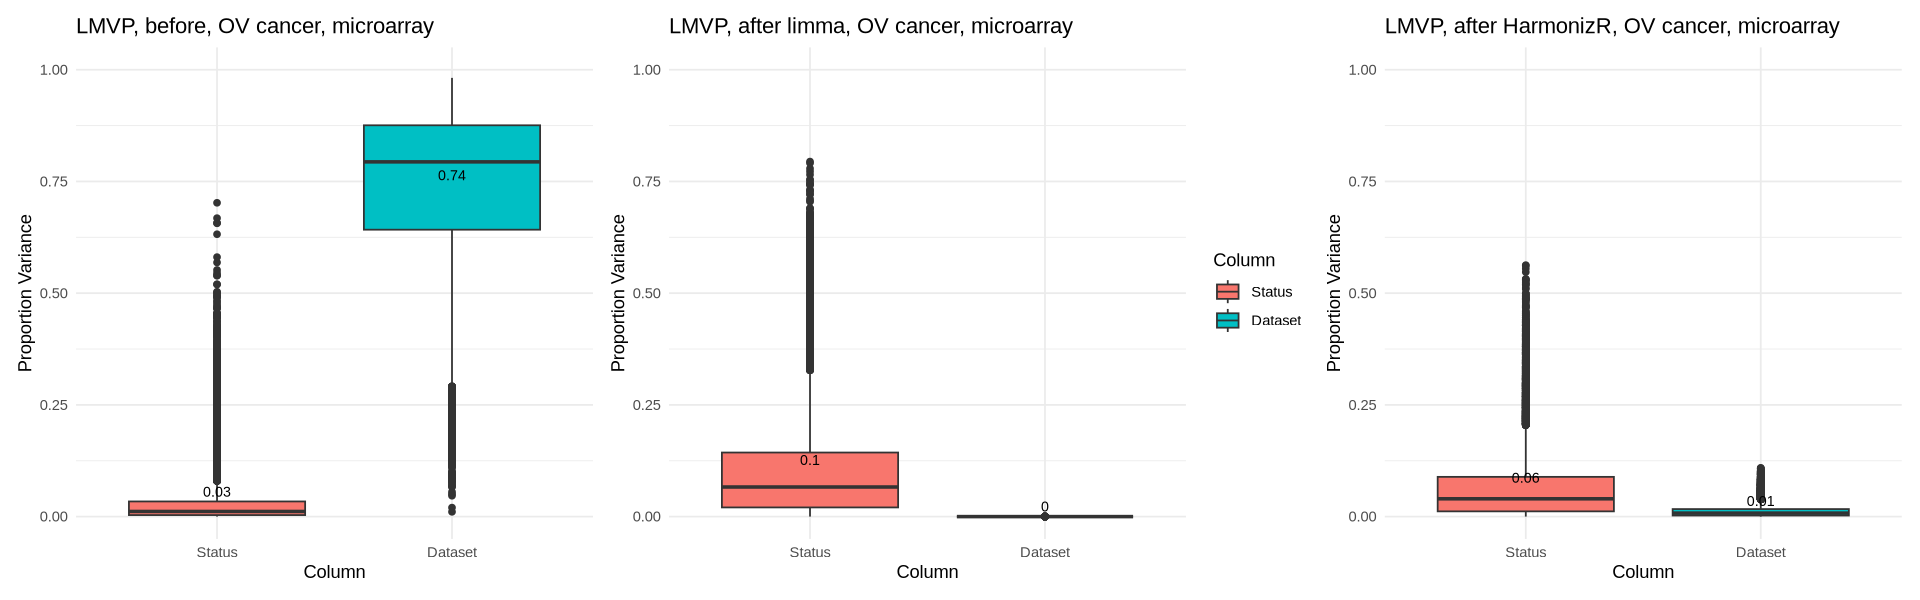

In [23]:
layout <- (lmpv_plot_uncorrected + lmpv_plots_Rcorrected + lmpv_plot_Hcorrected)
options(repr.plot.width=16, repr.plot.height=5)
layout

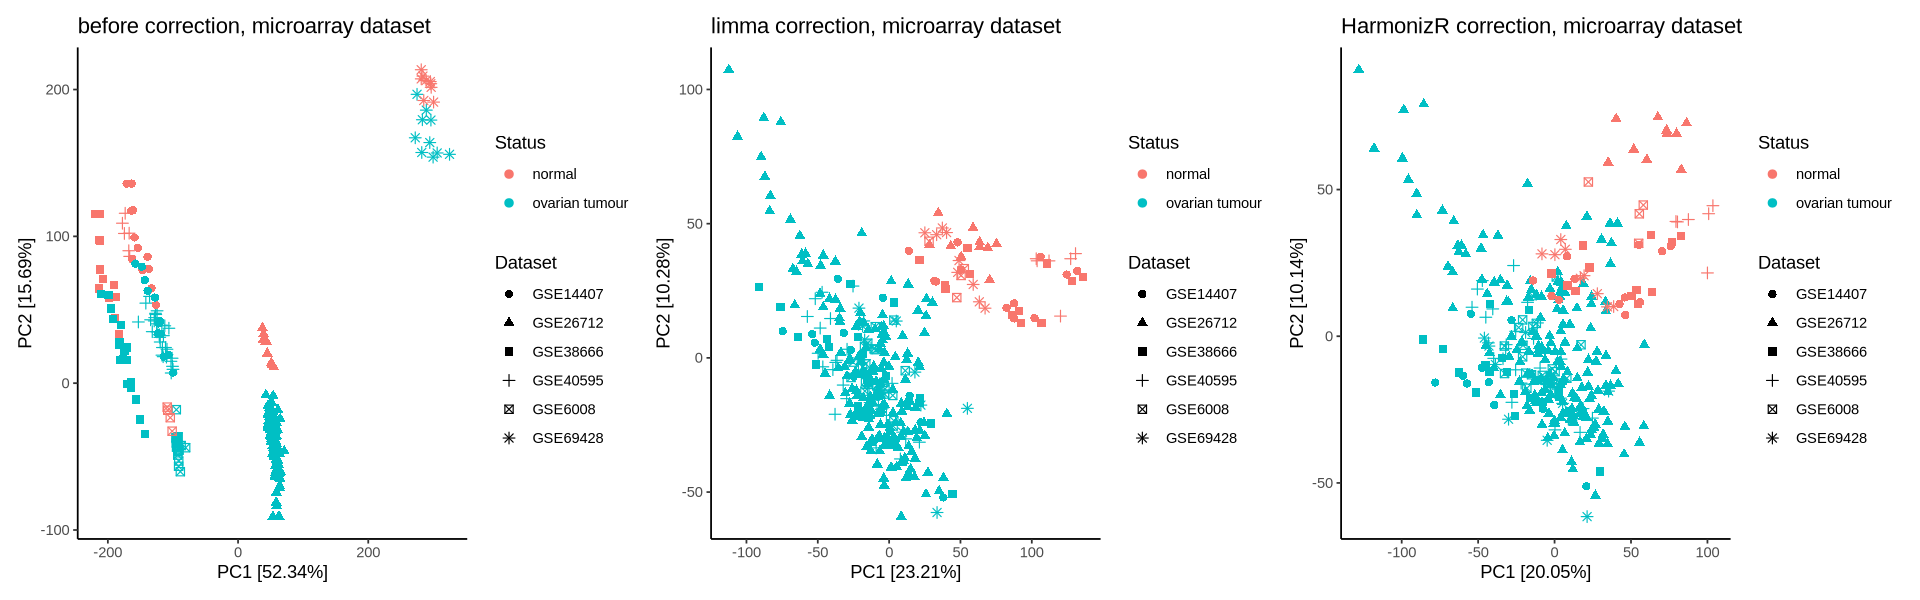

In [24]:
layout <- (before_correction_pca + after_limma_pca + after_H_pca)
options(repr.plot.width=16, repr.plot.height=5)
layout